## Import Libraries

In [50]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms 
import torchvision.datasets as datasets
import numpy as np

## Download the dataset And Apply Normalization

In [51]:
#Specify mean and Stander devition of all pixels in Mnist dataset --> precomputed
mean_gray = 0.1307
stddev_gray = 0.3081

# Transform the image to tenser
# Normalize the tenser using Mean and Stander_deviation

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((mean_gray),(stddev_gray))])

# loading The dataset
train_dataset = datasets.MNIST(root='./data',
                              train=True,
                              transform=transform,
                              download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform)

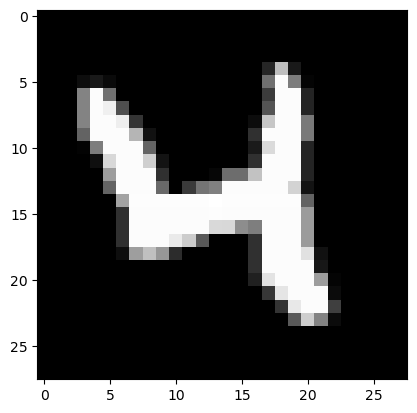

In [52]:
#Visulize training dataset
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28), cmap='gray')

In [53]:
train_dataset[20][1]

4

## Creat the DataLoader 

In [54]:
# Create the dataloader
batch_size =100
train_load = torch.utils.data.DataLoader(dataset = train_dataset 
                                        ,batch_size=batch_size,
                                        shuffle = True)
test_load = torch.utils.data.DataLoader(dataset = test_dataset 
                                        ,batch_size=batch_size,
                                        shuffle = False)

In [90]:
print(len(test_dataset))
print(len(test_load))
print("--------------")
print(len(train_dataset))
print(len(train_load))

10000
100
--------------
60000
600


## Building The CNN Network

In [56]:
# Building the network
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #same padding --> input_size = output_size 
        # input size =28
        #same padding =(Kernal_size-1)/2  (3-1)/2 = 1
        self.cnn1 = nn.Conv2d(in_channels=1 , out_channels=8 ,kernel_size=3 ,stride=1 ,padding=1)
        # output size of 8 feature map = ((input_size-filter_size +(2*padding))/stride) + 1
        #out_size = ((28 - 3 +(2*1))/1)+1 =28  
        self.batchnorm1 = nn.BatchNorm2d(8) 
        self.relu = nn.ReLU()
        self.maxpool= nn.MaxPool2d(kernel_size=2)
        #out_size =28/2 =14
        
        
        #same padding (kernal_size -1)/2 ---> (5-1)/2= 2
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1,padding=2)
        #out_size = ((input_size-filter_size +(2*padding))/stride) + 1
        #out_size= (14-5+(2*2)/1)  +1 -->14
        self.batchnorm2 = nn.BatchNorm2d(32)
        # after apllying maxpooling again the output size = 14/2 = 7
        
        #befer aplly fully conected layer we will flatten the image
        #Flatten the 32 feature map --> 32*7*7 = 1568
        self.fc1 = nn.Linear(1568,600)
        self.dropout = nn.Dropout(p=0.5) # apply dropout
        self.fc2 = nn.Linear(600,10) # we have 10 clasees
        
    def forward(self, x): 
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        #Flatten the 32 feature map from max pooling 2 to feed it to fc1 -- 32*7*7 = 1568
        out = out.view(-1,1568)
        #Then feed forward
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [57]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Understanding the propgation


In [58]:
iteration = 0 
correct = 0
for i, (inputs, labels) in enumerate (train_load):
    
    print('for one iteration this what happen ')
    #Each tenser prooagated through the network should be 4d
    #(batch_size, channel, rows ,columns)
    
    print('Input shape',inputs.shape)
    print('labels shape',labels.shape)
    
    output = model(inputs) # Aplly forward propagation
    print("output shape is",output.shape)
    
    _, predicted = torch.max(output,1)
    print("predicted shape is",predicted.shape)
    print("predicted tensor: \n",predicted)
    print(len(predicted))
    correct += (predicted == labels).sum()
    break

for one iteration this what happen 
Input shape torch.Size([100, 1, 28, 28])
labels shape torch.Size([100])
output shape is torch.Size([100, 10])
predicted shape is torch.Size([100])
predicted tensor: 
 tensor([9, 3, 5, 8, 3, 7, 7, 7, 8, 5, 4, 9, 8, 3, 7, 7, 3, 7, 7, 7, 5, 0, 5, 7,
        7, 3, 5, 7, 7, 9, 7, 8, 7, 7, 8, 8, 8, 8, 7, 3, 3, 0, 3, 9, 7, 7, 7, 7,
        7, 7, 7, 0, 3, 3, 7, 7, 7, 5, 7, 2, 3, 9, 2, 8, 5, 7, 7, 8, 7, 5, 7, 7,
        0, 7, 9, 5, 7, 3, 2, 0, 7, 8, 5, 5, 0, 5, 7, 9, 7, 7, 7, 7, 7, 5, 0, 8,
        7, 7, 7, 3])
100


In [60]:
#Training the CNN
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i, (inputs , labels) in enumerate(train_load):
       
        outputs = model(inputs) #Apply Forward propgation
        loss = loss_fn(outputs ,labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()# w--> w -lr* gradient
        loss.backward()  # aplly back propagation
        optimizer.step()
        
        _, predicted = torch.max(outputs ,1)
        correct += (predicted == labels).sum().item()
        iterations += 1
        
    train_loss.append(iter_loss / iterations)
    train_accuracy.append(100*correct /len(train_dataset))
    
  
    #Test phase
    testing_loss = 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    for i, (inputs , labels) in enumerate(test_load):
       
        outputs = model(inputs) #Apply Forward propgation
        loss = loss_fn(outputs ,labels)
        testing_loss += loss.item()
        
        _, predicted = torch.max(outputs ,1)
        correct += (predicted == labels).sum().item()
        iterations += 1
        
    test_loss.append(testing_loss/iterations)
    test_accuracy.append( (100*correct /len(test_dataset)) )
    
    print("Epoch {}/{}, Training Loss: {:.3f}, Training Accurcy: {:.3f}, Testing Loss: {:.3f}, Testing Accurcy: {:.3f}"
    .format( epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]  ))

Epoch 1/10, Training Loss: 0.106, Training Accurcy: 96.908, Testing Loss: 0.043, Testing Accurcy: 98.660
Epoch 2/10, Training Loss: 0.085, Training Accurcy: 97.655, Testing Loss: 0.043, Testing Accurcy: 98.750
Epoch 3/10, Training Loss: 0.070, Training Accurcy: 97.972, Testing Loss: 0.036, Testing Accurcy: 98.880
Epoch 4/10, Training Loss: 0.066, Training Accurcy: 98.100, Testing Loss: 0.037, Testing Accurcy: 98.930
Epoch 5/10, Training Loss: 0.061, Training Accurcy: 98.203, Testing Loss: 0.042, Testing Accurcy: 98.750
Epoch 6/10, Training Loss: 0.059, Training Accurcy: 98.277, Testing Loss: 0.035, Testing Accurcy: 98.950
Epoch 7/10, Training Loss: 0.055, Training Accurcy: 98.395, Testing Loss: 0.036, Testing Accurcy: 98.900
Epoch 8/10, Training Loss: 0.055, Training Accurcy: 98.362, Testing Loss: 0.047, Testing Accurcy: 98.790
Epoch 9/10, Training Loss: 0.052, Training Accurcy: 98.525, Testing Loss: 0.043, Testing Accurcy: 98.770
Epoch 10/10, Training Loss: 0.051, Training Accurcy: 98

In [73]:
for loss in train_loss:
    print("{:.3f}".format(loss))

0.106
0.085
0.070
0.066
0.061
0.059
0.055
0.055
0.052
0.051


## Visualize Loss And Acurcy for Testing And Training

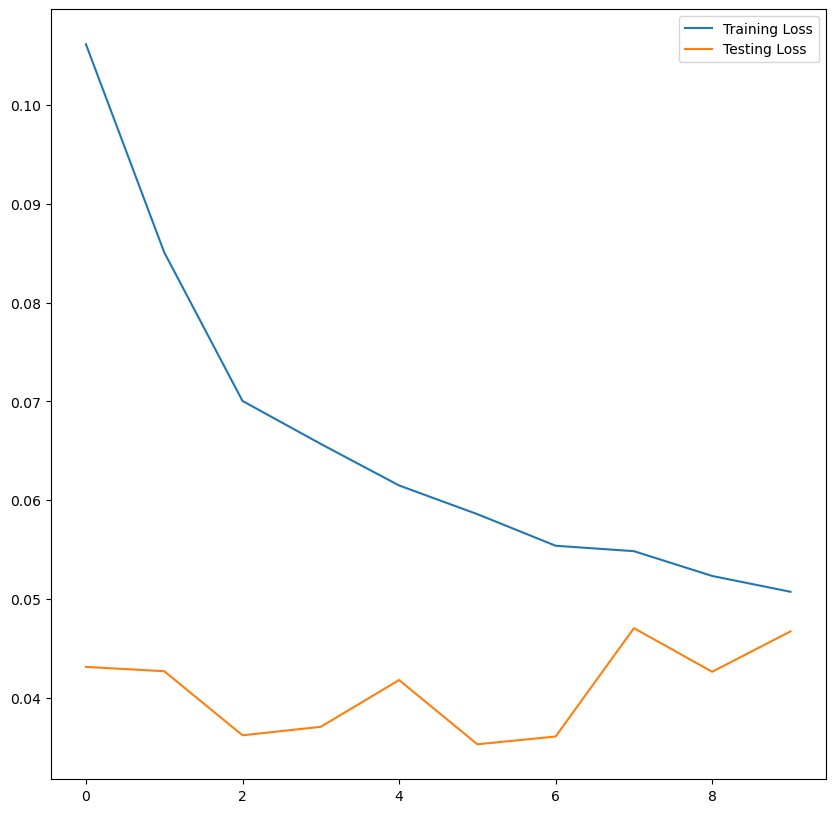

In [68]:
# plotting the loss

f = plt.figure(figsize = (10,10))
plt.plot(train_loss ,label ='Training Loss')
plt.plot(test_loss,label ='Testing Loss' )
plt.legend()
plt.show()

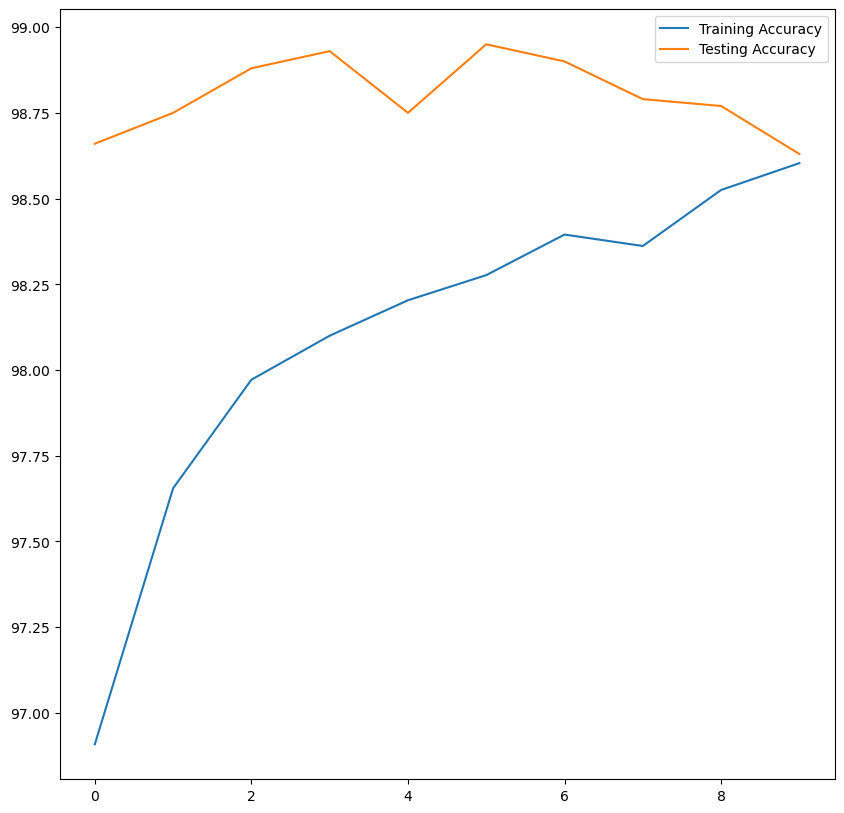

In [75]:
# plotting the Accurcy 
f = plt.figure(figsize = (10,10))
plt.plot(train_accuracy,label='Training Accuracy')
plt.plot(test_accuracy,label='Testing Accuracy')
plt.legend()
plt.show()

## Testing an Image

In [95]:
imge = test_dataset[20][0].resize(1,1,28,28)   #Image itself --> Resize it (batch_size ,num_channel, rows, colums)
label = test_dataset[20][1] # the label
model.eval()
output = model(imge)
_, predict = torch.max(output,1)
print("Prediction is {}".format(predict.item()))
print("Label is {}".format(label))

Prediction is 9
Label is 9
